In [1]:
## FINESSE PACKAGE IMPORTS ##
import finesse
from finesse.components import Laser, Lens, Mirror, Nothing, Space, Cavity

## INTERNAL PACKAGES ##
from PIL import Image
from pathlib import Path
from pprint import pprint
from itertools import zip_longest
    
## EXTERNAL PACKAGES ##
import matplotlib.pyplot as plt
import numpy as np

## USER PACAKGES ##
from setup_finesse import calculate_nr, setup_simple, setup_cavity_with_crystal, get_relevant_qs

# Upper Bound for $\omega_0$

When the light bounces inside the cavity with a crystal inside of it, the spot size or beam radius should not exceed the cross-sectional area of the phase-matching channel ($A=0.5\times 0.5$mm).
If it does, the light will also travel through glass cover instead of the crystal; the finesse of the cavity will be compromised.
The beam radius changes with a function of propagation distance according to:

$$\omega(z) = \omega_0 \sqrt{1 + \frac{z}{z_R}^2} \quad (1)$$

Our condition is $\omega(z_R) < 0.5$mm.
Plugging this into Eqn (1):
$\omega_0 < \frac{\sqrt{2}}{4}$mm

We can model our cavity as a series of lenses with $f=0.5$m, seperated by free-space and repeatitions of a crystal.

**Assumption: The beam has already been focused down such that, at a distance of $\frac{L}{2}$ away from the first mirror (ie. at the centre of the crystal), $\omega_0 = \frac{\sqrt{2}}{4}$mm.**

*Question: What does the beam's radius look like at the centre of the crystal and at each mirror's face as it propagates through the cavity?*
*What would it look like for different cavity lengths?*

# $\omega_0=\frac{\sqrt{2}}{4}$mm

In [10]:
W_UPPER_BOUND = (2**0.5)*(1e-3)/4
q_i = finesse.gaussian.BeamParam(wavelength=1550e-9, w0=W_UPPER_BOUND,z=10e-3)

In [3]:
def plot_everything(qs_for_each_L, Ls):
    crys_ws = [[q.w for q in qs["crystals"]["qs"]] for qs in qs_for_each_L]
    crys_zs = [[z for z in qs["crystals"]["zs"]] for qs in qs_for_each_L]
    
    left_mirror_ws = [[q.w for q in qs["mirrors"]["left"]["qs"]] for qs in qs_for_each_L]
    left_mirror_zs = [[z for z in qs["mirrors"]["left"]["zs"]] for qs in qs_for_each_L]

    right_mirror_ws = [[q.w for q in qs["mirrors"]["right"]["qs"]] for qs in qs_for_each_L]
    right_mirror_zs = [[z for z in qs["mirrors"]["right"]["zs"]] for qs in qs_for_each_L]

    fig = plt.figure(layout="constrained", figsize=(8,8))
    fig.suptitle("Radii of the Beam at the Crystal's edges (red) and at the left and right mirrors (blue)")
    fig.supxlabel("Distance Propagated, "+r"$z$,"+" [m]")
    fig.supylabel("Beam Radius, "+r"$\omega$,"+" [mm]")
    
    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=len(Ls), ncols=1)
    for L, subfig in enumerate(subfigs):
        subfig.suptitle(r"$L=$"+str(Ls[L])+"m")
    
        # create 1x3 subplots per subfig
        ax = subfig.subplots(nrows=1, ncols=3, sharey=True)
        ax[0].plot(crys_zs[L], 1000*np.array(crys_ws[L]), color="tab:red", label=L)
        ax[1].plot(left_mirror_zs[L], 1000*np.array(right_mirror_ws[L]), color="tab:blue", label=L)
        ax[2].plot(right_mirror_zs[L], 1000*np.array(right_mirror_ws[L]), color="tab:blue", label=L)
    
        ax[0].hlines(0.5, ax[0].get_xlim()[0], ax[0].get_xlim()[1], color="black", linestyle="dashed")
        ax[1].hlines(0.5, ax[1].get_xlim()[0], ax[1].get_xlim()[1], color="black", linestyle="dashed")
        ax[2].hlines(0.5, ax[1].get_xlim()[0], ax[1].get_xlim()[1], color="black", linestyle="dashed")


## Cavities Lengths in Steps of 0.25m

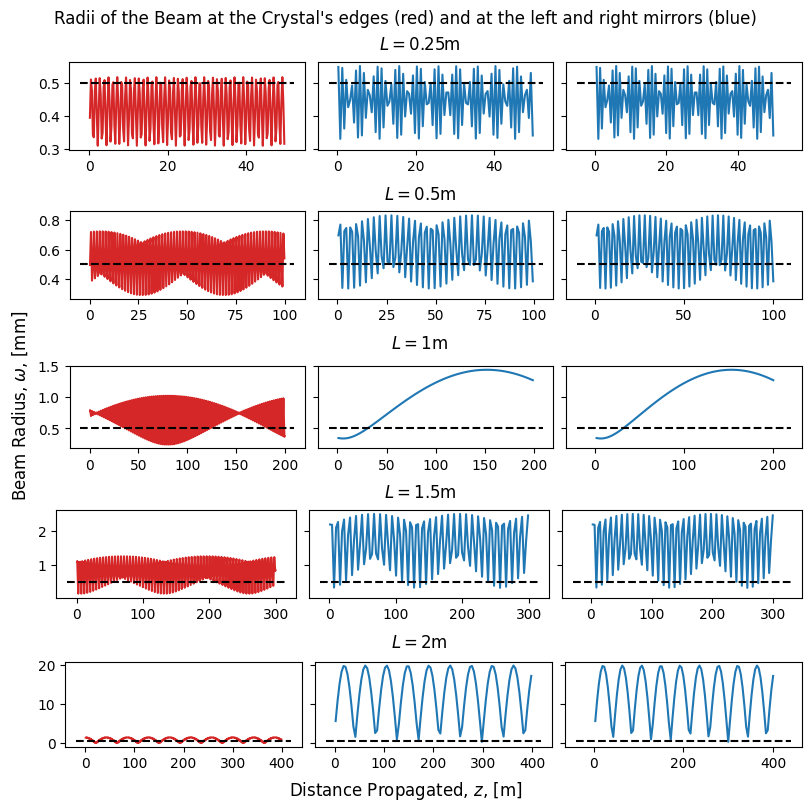

In [4]:
Ls_big = [0.25, 0.5, 1, 1.5, 2]
qs_big = [get_relevant_qs(200, L, q_i) for L in Ls_big]

plot_everything(qs_big, Ls_big)

plt.show()

### Conclusion

Clearly, the spotsize outgrew our upper limit (dashed line).
Smaller cavities yielded more consistent spot sizes for each reflection.
This is worth exploring, with the same $q_in$.

## Cavities Lengths in Steps of 0.01m Below 0.25m

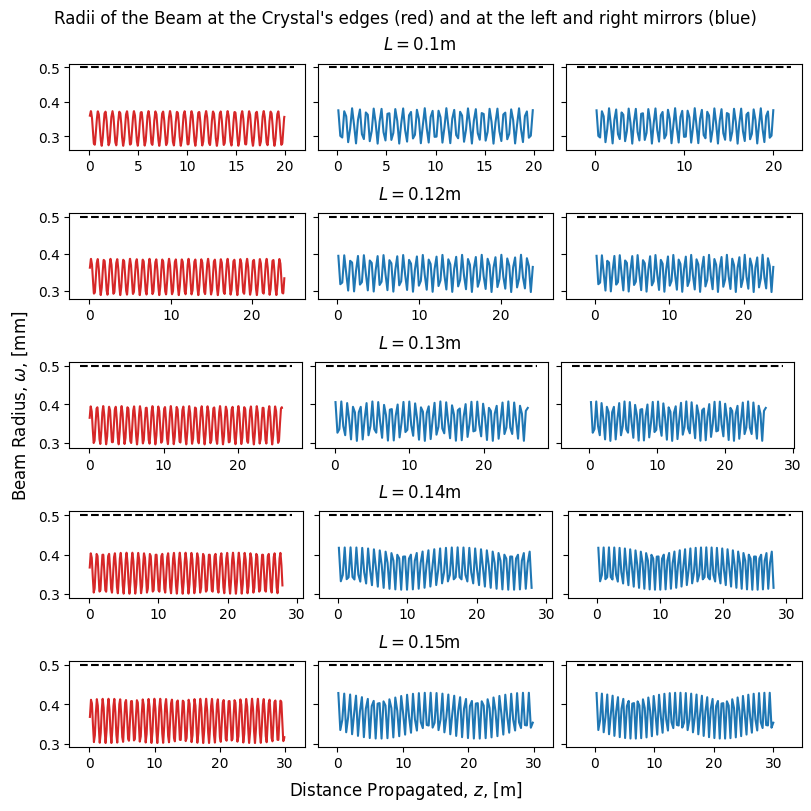

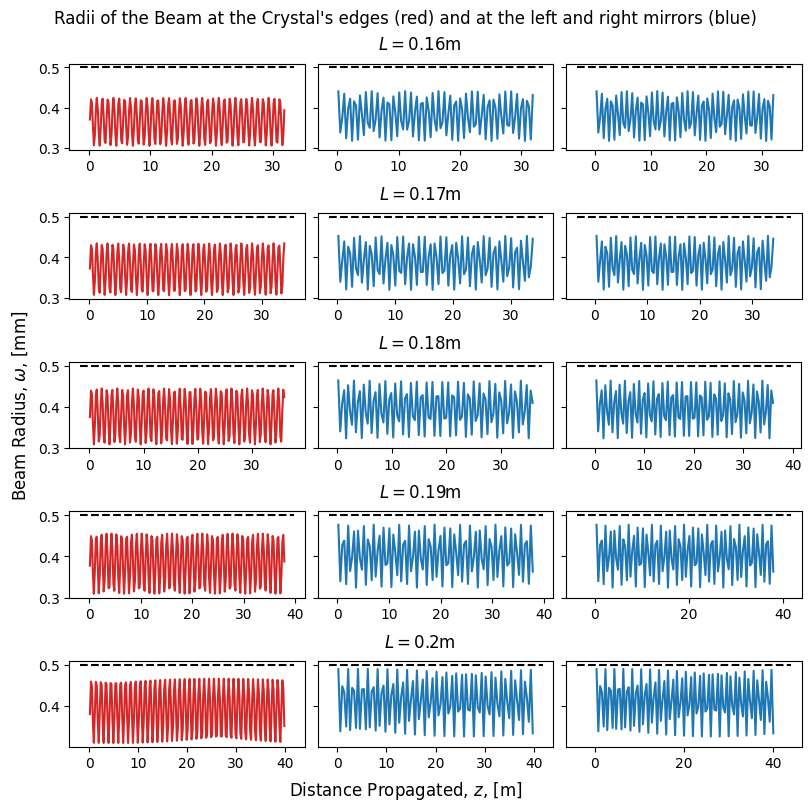

In [5]:
Ls_10_15 = [0.1, 0.12, 0.13, 0.14, 0.15]
qs_10_15 = [get_relevant_qs(200, L, q_i) for L in Ls_10_15]
plot_everything(qs_10_15, Ls_10_15)

Ls_16_20 = [0.16, 0.17, 0.18, 0.19, 0.2]
qs_16_20 = [get_relevant_qs(200, L, q_i) for L in Ls_16_20]
plot_everything(qs_16_20, Ls_16_20)
plt.show()

### Conclusion

As the length of the cavity increased, on average the spot size drifted away from the target upper bound spot size (dashed line).
There seems to be some noticable periodicity at 0.2m and 0.19m.

# Doubling the Rayleigh range

Now an investigation into focusing the beam to a smaller spot size at the beginning is worth doing.
The last $z_R$ was matched to half the crystal length in order to optimise the efficiency of the SPDC process.
Unfortunately, to make this cavity feasible, this efficiency will have to be compromised.
If the $z_R$ were to double in legnth (10mm -> 20mm):

In [6]:
W_TWICE_ZR = ((6**0.5)/6)*1e-3
q_twice_zr = finesse.gaussian.BeamParam(wavelength=1550e-9, w0=W_TWICE_ZR,z=10e-3)
print(q_twice_zr)

BeamParam(w0=408.25 um, z=10 mm, w=408.43 um, Rc=11.421 m)


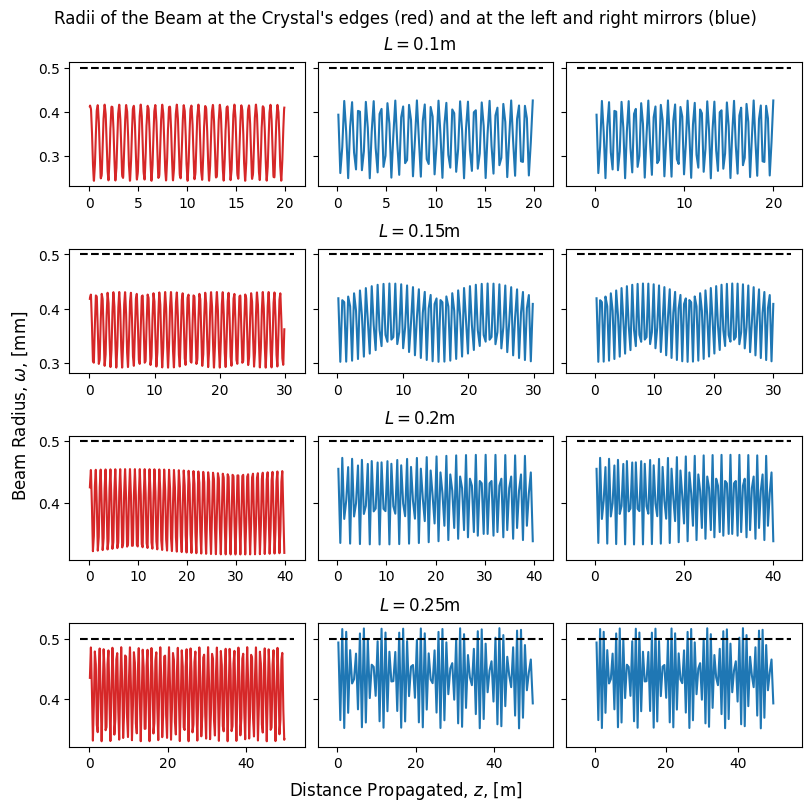

In [7]:
Ls_10_25 = [0.1, 0.15, 0.2, 0.25]
qs_10_25 = [get_relevant_qs(200, L, q_twice_zr) for L in Ls_10_25]
plot_everything(qs_10_25, Ls_10_25)
plt.show()

### Conclusion

That looks *much* better!
The beam is completely contained inside the crystal as it travels through it, with some wiggle room to spare!
As we go towards a 0.25m cavity, we have less wiggle room to work with.
Something to keep in mind.

# Current Beam-Parameters $\omega_0 = 50$um

What if we used the same beam parameters that we have currently downstairs on the bench?
Here, the beam radius is around 50 microns!

In [8]:
W_FOCUSED = 50e-6
q_focu = finesse.gaussian.BeamParam(wavelength=1550e-9, w0=W_FOCUSED,z=10e-3)
print(q_focu)

BeamParam(w0=50 um, z=10 mm, w=110.62 um, Rc=12.568 mm)


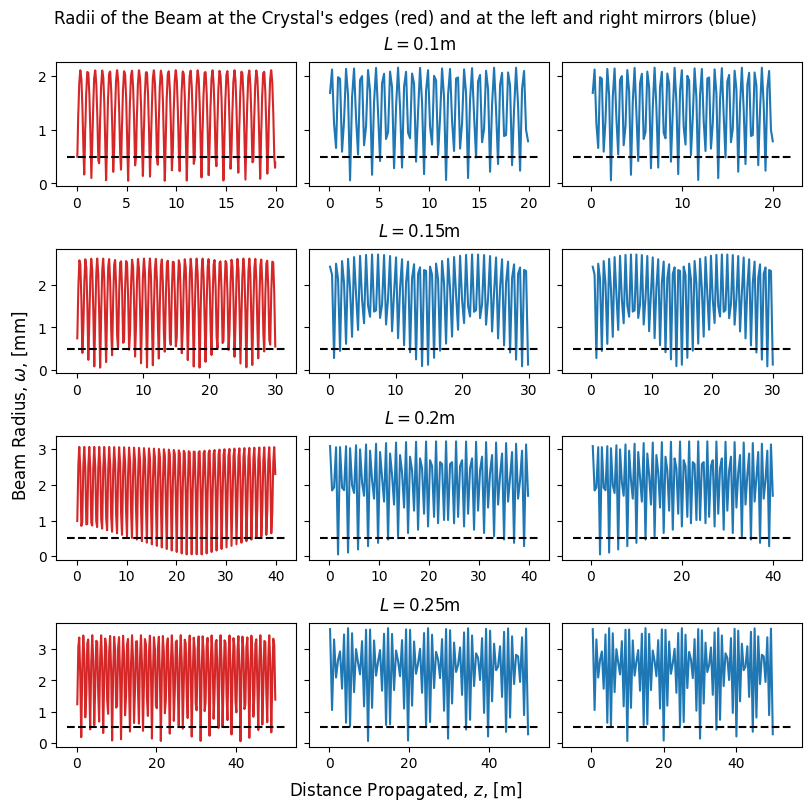

In [9]:
Ls_10_25 = [0.1, 0.15, 0.2, 0.25]
qs_10_25 = [get_relevant_qs(200, L, q_focu) for L in Ls_10_25]
plot_everything(qs_10_25, Ls_10_25)
plt.show()

## Conclusion

This demonstrates that the current setup is not sufficient; It is not a simple case of plonking mirrors around the crystal with this lens configuration.